#### Loan Approval System

Author: Mohammed Iftkhar

Date: 29th March, 2025

##### Introduction
In the modern financial landscape, loan approval decisions play a crucial role in banking and credit systems. Traditionally, loan approval was based on manual assessment, leading to inefficiencies and potential biases. This project aims to build a Loan Approval System using machine learning (ML) and deep learning techniques to automate, optimize, and enhance the accuracy of loan approval decisions.

By leveraging data preprocessing, exploratory data analysis (EDA), feature engineering, feature selection, and multiple ML models, this project provides an intelligent loan approval system capable of making data-driven decisions.

##### Description
The project follows a systematic approach to data-driven loan approval using machine learning techniques:

1. Data Collection & Preprocessing
- Load the dataset, clean missing values, and standardize column names.
- Convert categorical variables into numerical values.
- Handle outliers using statistical techniques.

2. Exploratory Data Analysis (EDA)
- Perform statistical analysis and visualization to understand the dataset.
- Identify key patterns and relationships among loan approval factors.

3. Feature Engineering & Selection
- Engineer new features such as loan-to-income ratio and asset-to-loan ratio.
- Select the most important features using ANOVA F-test to enhance model performance.

4. Model Training & Evaluation

    ✅ Train multiple machine learning models, including:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)
- Gradient Boosting

    ✅ Use SMOTE to handle class imbalance.

    ✅ Evaluate models using accuracy, precision, recall, F1-score, and ROC-AUC curves.

5. Neural Network Implementation
- Build and train a deep learning model using TensorFlow & Keras.
- Implement Batch Normalization, Dropout, and Early Stopping for optimization.

6. Model Selection & Deployment
- Select the best-performing model (Random Forest in this case).
- Save the trained model using joblib for future predictions.



In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE

In [2]:
# Scikit-learn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
# Tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

##### Configurations

In [4]:
warnings.filterwarnings("ignore")

# Set aesthetic parameters
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

##### Load Dataset

In [5]:
# Load and inspect dataset
def load_data():
    df = pd.read_csv("data.csv")
    print("Dataset loaded successfully!")
    print(f"\nShape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    return df

##### Data Cleaning

In [6]:
# Data Cleaning and Preprocessing
def clean_data(df):
    # Make column names consistent
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    # Handle missing values
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())

    # Drop rows with missing values (alternative: imputation could be used)
    df.dropna(inplace=True)

    # Convert data types
    numeric_cols = [
        "no_of_dependents",
        "income_annum",
        "loan_amount",
        "loan_term",
        "cibil_score",
        "residential_assets_value",
        "commercial_assets_value",
        "luxury_assets_value",
        "bank_asset_value",
    ]

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("int64")

    print("\nMissing values after cleaning:")
    print(df.isnull().sum())

    return df

##### Exploratory Data Analysis

In [7]:
def perform_eda(df):
    print("\nBasic Statistics:")
    display(df.describe())

    print("\nCategorical Features Distribution:")
    cat_cols = ["education", "self_employed", "loan_status"]
    for col in cat_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, palette="viridis")
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()
        print(df[col].value_counts(normalize=True))

    # Correlation analysis
    plt.figure(figsize=(12, 8))
    corr = df.corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

    # Identify highly correlated features
    high_corr = []
    for col in corr.columns:
        high_corr_count = (corr[col].abs() > 0.8).sum() - 1  # Exclude self-correlation
        if high_corr_count >= 1:
            high_corr.append(col)

    print("\nFeatures with high correlation (>0.8):", high_corr)

    # Visualize numeric features with dynamic layout
    numeric_features = df.select_dtypes(include=["int64"]).columns
    num_features = len(numeric_features)

    # Calculate optimal grid size
    cols = 3
    rows = (num_features // cols) + (1 if num_features % cols else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case it's a 2D array

    for i, col in enumerate(numeric_features):
        if i < len(axes):  # Ensure we don't exceed the number of subplots
            sns.histplot(data=df, x=col, bins=20, kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Distribution of Numeric Features", y=1.02)
    plt.tight_layout()
    plt.show()

    return df

In [8]:
# Feature Engineering
def engineer_features(df):
    # Drop loan_id as it's just an identifier
    df.drop("loan_id", axis=1, inplace=True)

    # Create new features
    df["total_assets"] = (
        df["residential_assets_value"]
        + df["commercial_assets_value"]
        + df["luxury_assets_value"]
        + df["bank_asset_value"]
    )

    df["loan_to_income_ratio"] = df["loan_amount"] / df["income_annum"]
    df["asset_to_loan_ratio"] = df["total_assets"] / df["loan_amount"]

    # Encode categorical features
    le = LabelEncoder()
    df["education"] = le.fit_transform(df["education"])
    df["self_employed"] = le.fit_transform(df["self_employed"])
    df["loan_status"] = le.fit_transform(df["loan_status"])

    # Handle outliers using winsorization
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[col] = np.where(df[col] < q1, q1, df[col])
        df[col] = np.where(df[col] > q3, q3, df[col])

    return df

In [9]:
# Feature Selection
def select_features(df):
    X = df.drop("loan_status", axis=1)
    y = df["loan_status"]

    # Feature selection using ANOVA F-value
    selector = SelectKBest(f_classif, k="all")
    selector.fit(X, y)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_scores = pd.DataFrame({"Feature": X.columns, "Score": selector.scores_})
    feature_scores = feature_scores.sort_values("Score", ascending=False)

    sns.barplot(data=feature_scores, x="Score", y="Feature", palette="viridis")
    plt.title("Feature Importance Scores (ANOVA F-value)")
    plt.xlabel("F-value")
    plt.tight_layout()
    plt.show()

    # Select top features
    selected_features = feature_scores[feature_scores["Score"] > 10]["Feature"].tolist()
    print("\nSelected features:", selected_features)

    return df[selected_features + ["loan_status"]]

In [10]:
# Model Training and Evaluation
def train_models(df):
    X = df.drop("loan_status", axis=1)
    y = df["loan_status"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "KNN": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    }

    # Train and evaluate models
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_prob = (
            model.predict_proba(X_test)[:, 1]
            if hasattr(model, "predict_proba")
            else [0] * len(y_test)
        )

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if any(y_prob) else 0
        report = classification_report(y_test, y_pred, output_dict=True)

        results.append(
            {
                "Model": name,
                "Accuracy": accuracy,
                "Precision": report["weighted avg"]["precision"],
                "Recall": report["weighted avg"]["recall"],
                "F1-Score": report["weighted avg"]["f1-score"],
                "ROC AUC": roc_auc,
            }
        )

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Rejected", "Approved"],
            yticklabels=["Rejected", "Approved"],
        )
        plt.title(f"{name} Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        # Plot ROC curve if applicable
        if any(y_prob):
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], "k--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.show()

    # Display results
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("Accuracy", ascending=False)

    print("\nModel Performance Comparison:")
    display(
        results_df.style.background_gradient(
            cmap="viridis", subset=["Accuracy", "ROC AUC"]
        )
    )

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    results_df.set_index("Model").plot(
        kind="bar",
        y=["Accuracy", "F1-Score", "ROC AUC"],
        color=["#3498db", "#2ecc71", "#9b59b6"],
    )
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0.5, 1.0)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return results_df, X_train, X_test, y_train, y_test, scaler

In [11]:
# Neural Network Model
def build_nn(X_train, y_train, X_test, y_test):
    model = Sequential(
        [
            Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC()],
    )

    early_stop = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1,
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred))

    return model

In [12]:
# Main execution
def main():
    # Load and preprocess data
    df = load_data()
    df = clean_data(df)
    df = perform_eda(df)
    df = engineer_features(df)
    df = select_features(df)

    # Train traditional ML models
    results_df, X_train, X_test, y_train, y_test, scaler = train_models(df)

    # Train neural network
    # nn_model = build_nn(X_train, y_train, X_test, y_test)

    # Save best model (Random Forest in this case)
    best_model = RandomForestClassifier(random_state=42)
    best_model.fit(
        scaler.fit_transform(df.drop("loan_status", axis=1)), df["loan_status"]
    )

    import joblib

    joblib.dump(best_model, "loan_approval_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    print("\nBest model saved as 'loan_approval_model.pkl'")

Dataset loaded successfully!

Shape: (4269, 13)

First 5 rows:


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2.0,Graduate,No,9600000.0,29900000.0,12.0,778.0,2400000.0,17600000.0,22700000.0,8000000.0,Approved
1,2,0.0,Not Graduate,Yes,4100000.0,12200000.0,8.0,417.0,2700000.0,2200000.0,8800000.0,3300000.0,Rejected
2,3,3.0,Graduate,No,9100000.0,29700000.0,20.0,506.0,7100000.0,4500000.0,33300000.0,12800000.0,Rejected
3,4,3.0,Graduate,No,8200000.0,30700000.0,8.0,467.0,18200000.0,3300000.0,23300000.0,7900000.0,Rejected
4,5,5.0,Not Graduate,Yes,9800000.0,24200000.0,20.0,382.0,12400000.0,8200000.0,29400000.0,5000000.0,Rejected



Missing values before cleaning:
loan_id                      0
no_of_dependents             2
education                    4
self_employed                5
income_annum                 5
loan_amount                 16
loan_term                    2
cibil_score                  2
residential_assets_value    13
commercial_assets_value     13
luxury_assets_value          6
bank_asset_value             2
loan_status                  0
dtype: int64

Missing values after cleaning:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Basic Statistics:


,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4222.000000,4222.000000,4.222000e+03,4.222000e+03,4222.000000,4222.000000,4.222000e+03,4.222000e+03,4.222000e+03,4.222000e+03
mean,2126.024870,2.496921,5.054287e+06,1.512560e+07,10.905732,599.847939,7.464993e+06,4.974112e+06,1.511805e+07,4.971743e+06
std,1224.838107,1.696985,2.808323e+06,9.043200e+06,5.713372,172.754124,6.505117e+06,4.385391e+06,9.111921e+06,3.252408e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1067.250000,1.000000,2.600000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2122.500000,3.000000,5.100000e+06,1.450000e+07,10.000000,599.500000,5.600000e+06,3.700000e+06,1.460000e+07,4.500000e+06
75%,3177.750000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07



Categorical Features Distribution:


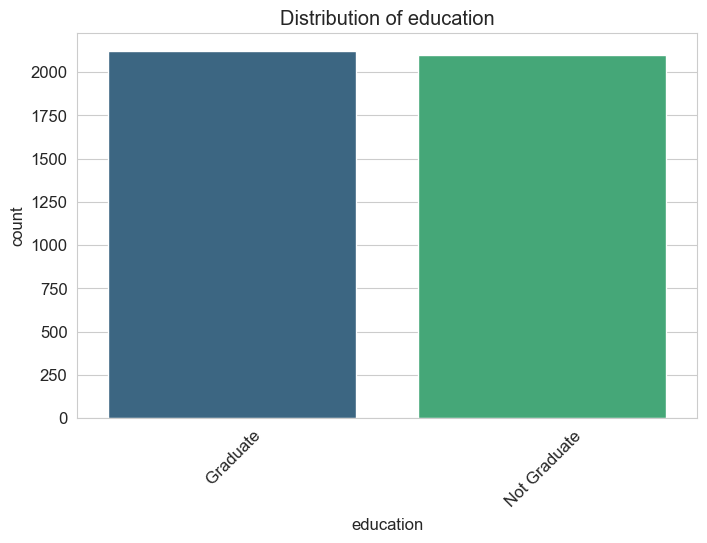

education
Graduate        0.502132
Not Graduate    0.497868
Name: proportion, dtype: float64


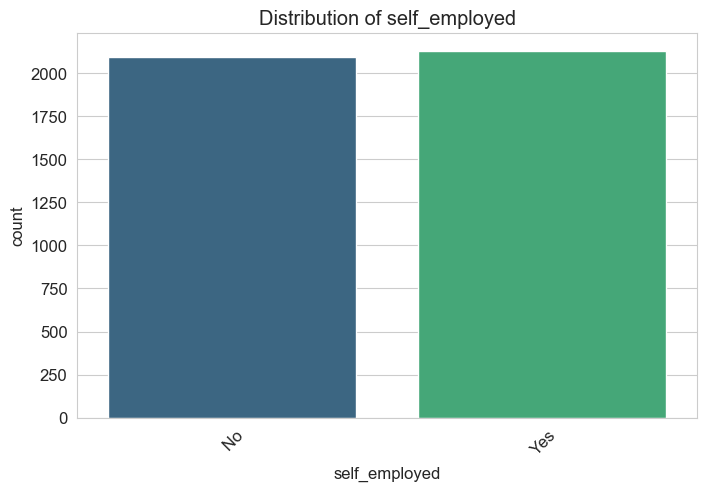

self_employed
Yes    0.50379
No     0.49621
Name: proportion, dtype: float64


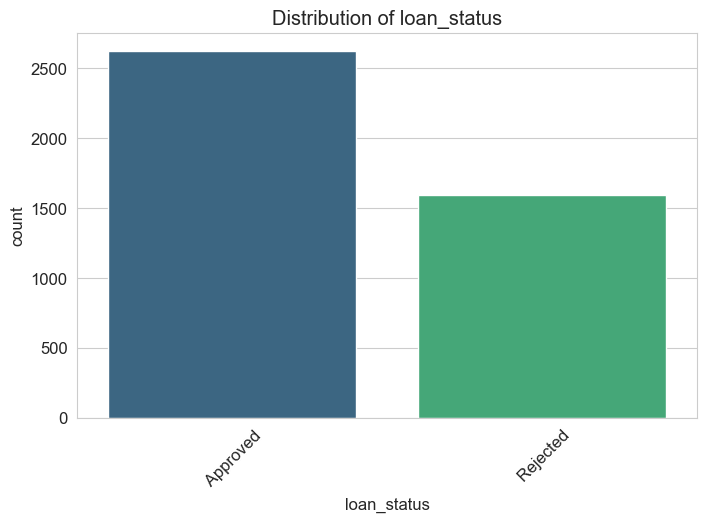

loan_status
Approved    0.621743
Rejected    0.378257
Name: proportion, dtype: float64


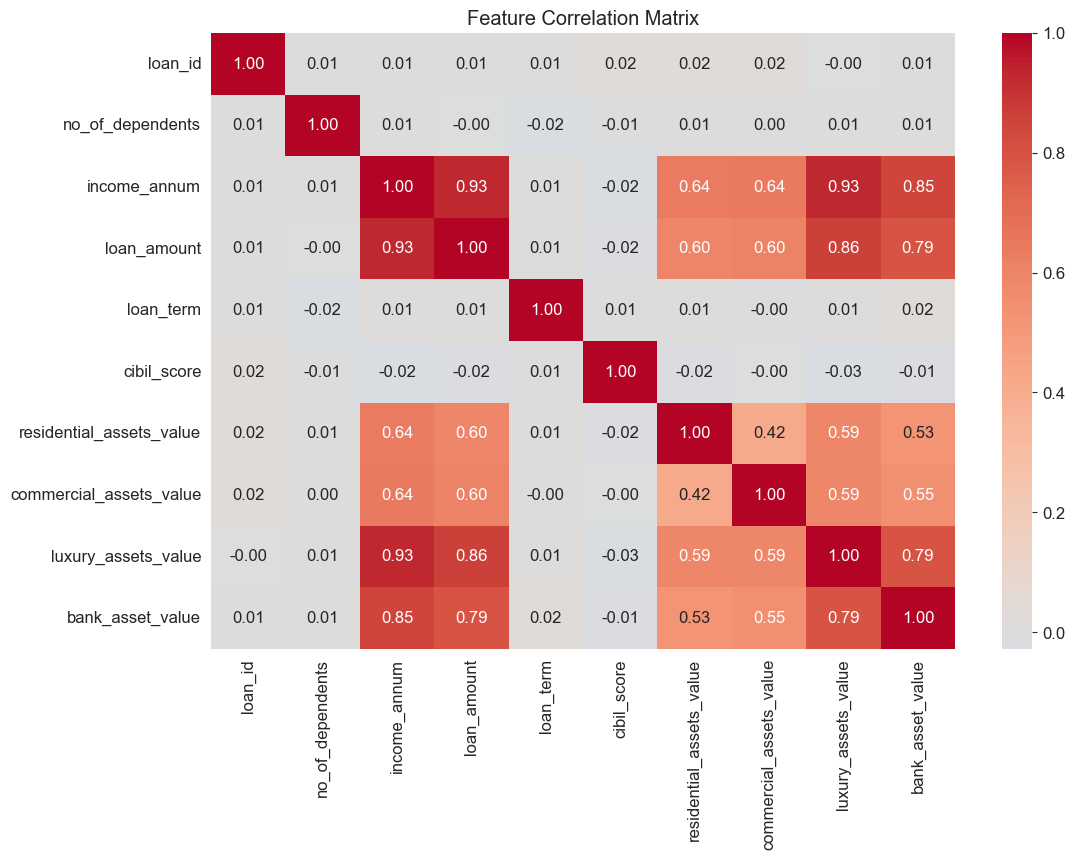


Features with high correlation (>0.8): ['income_annum', 'loan_amount', 'luxury_assets_value', 'bank_asset_value']


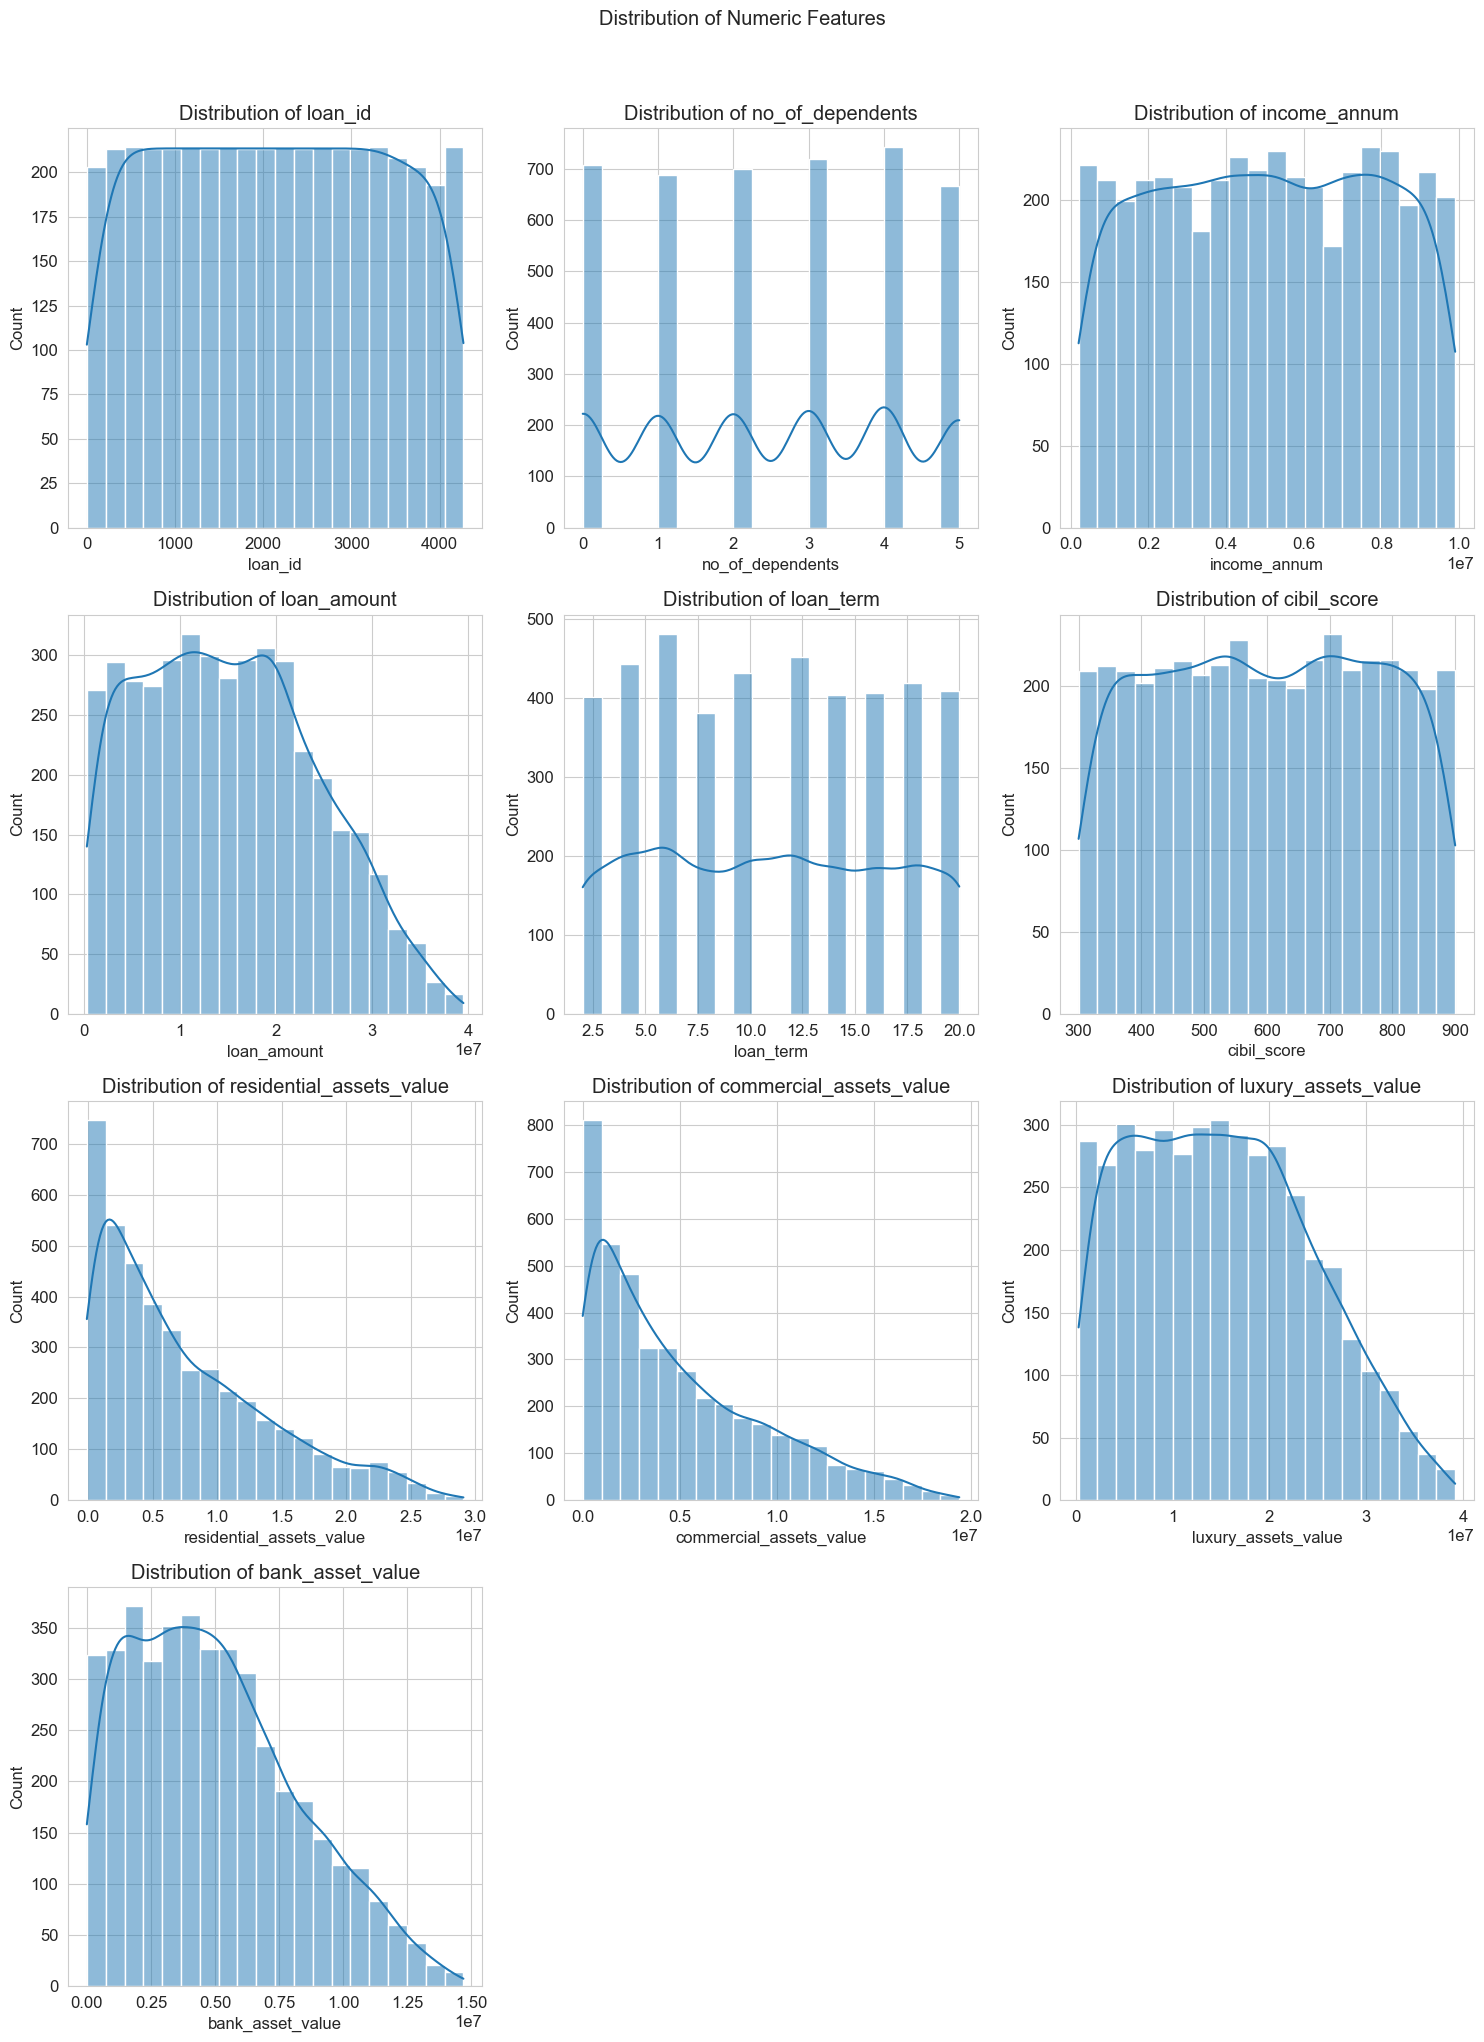

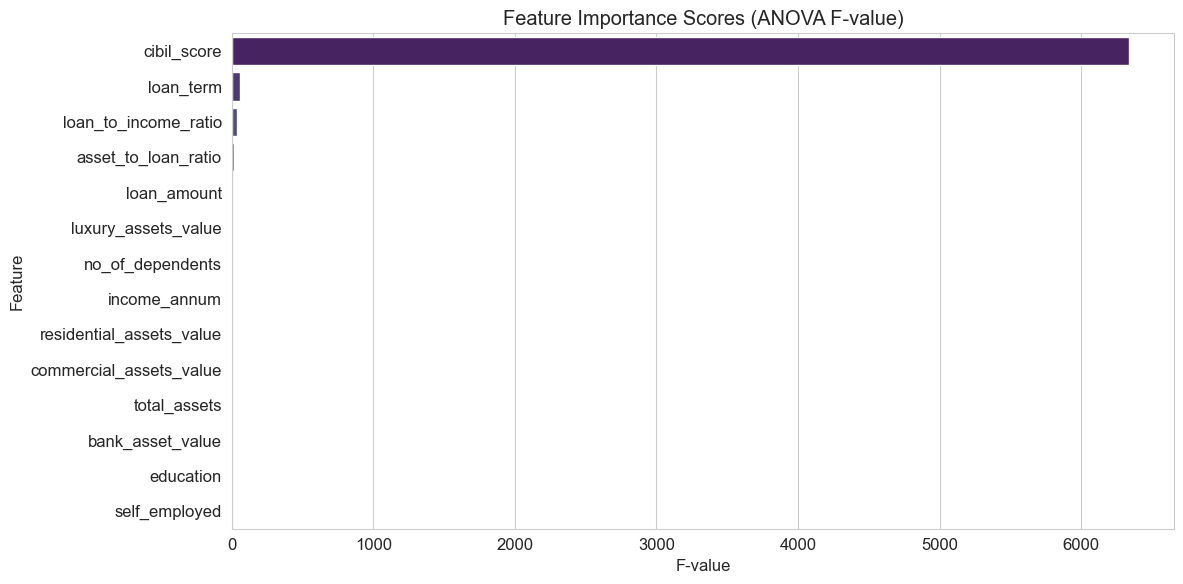


Selected features: ['cibil_score', 'loan_term', 'loan_to_income_ratio', 'asset_to_loan_ratio']


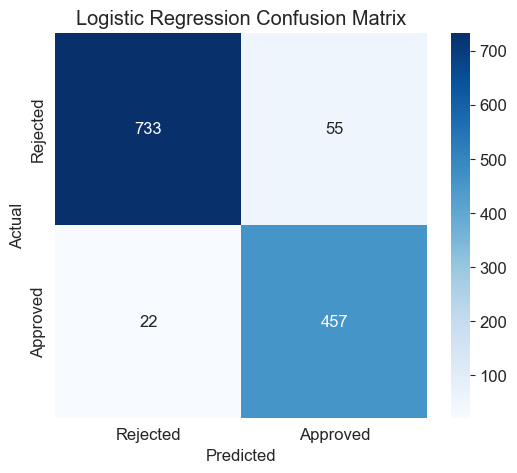

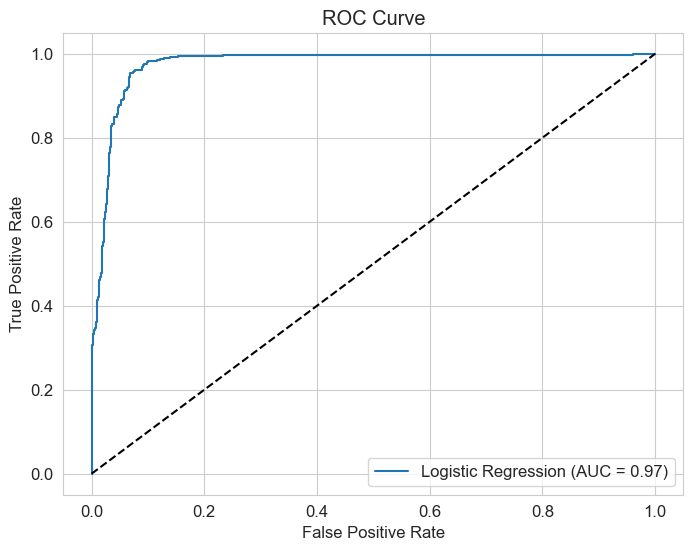

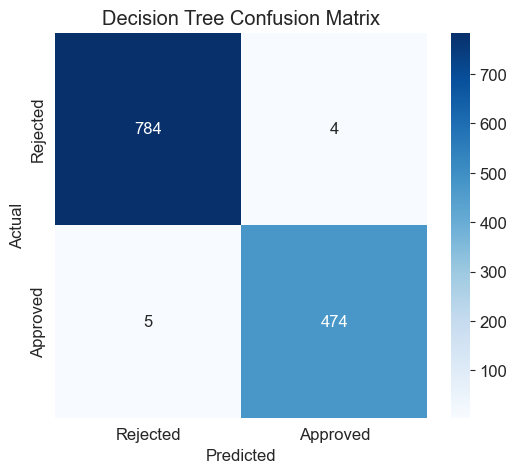

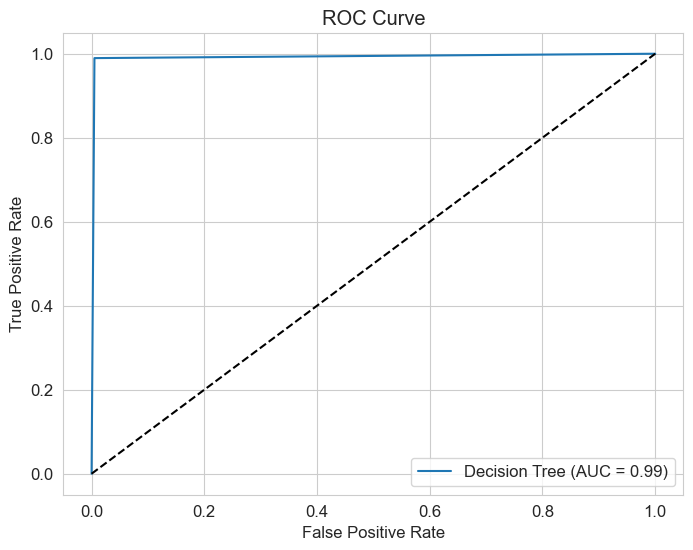

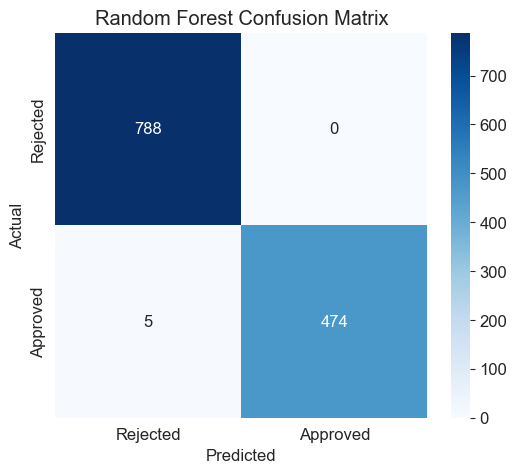

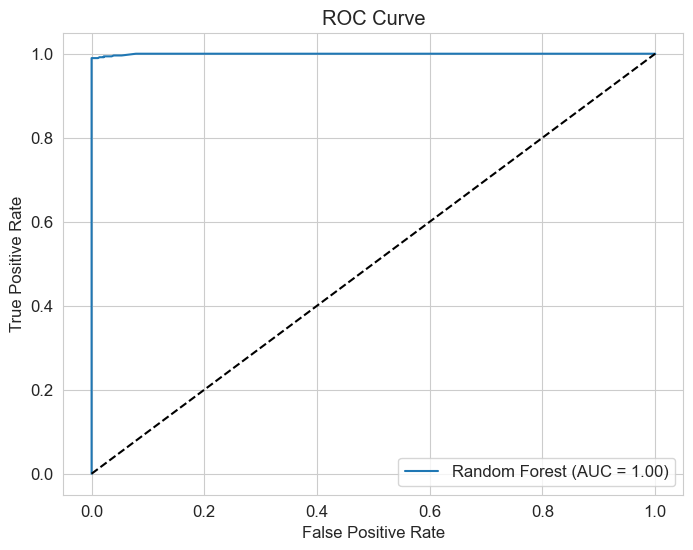

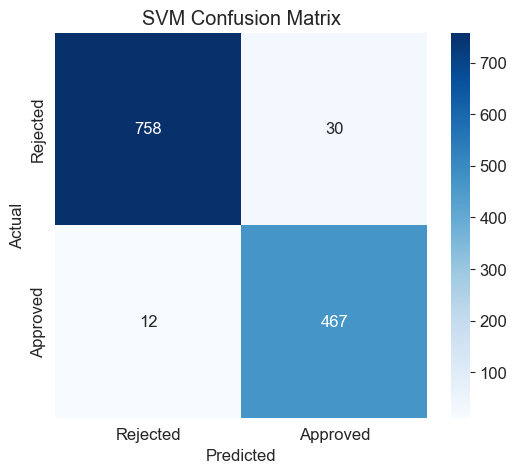

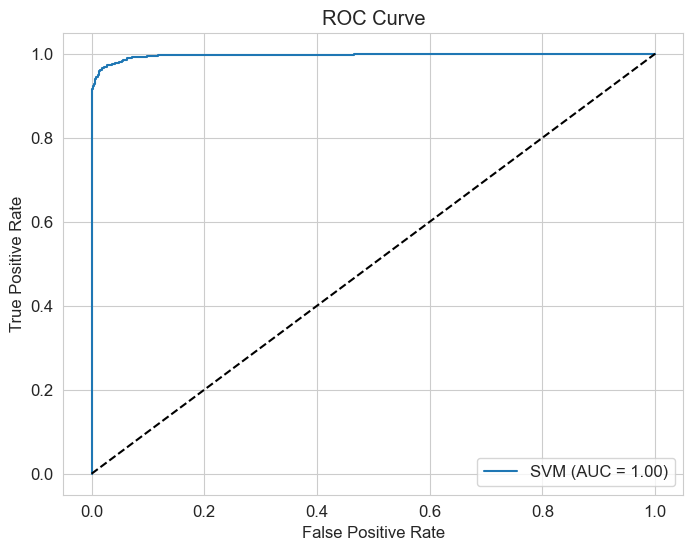

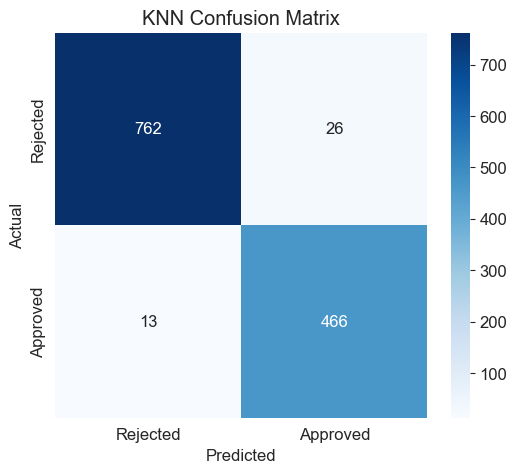

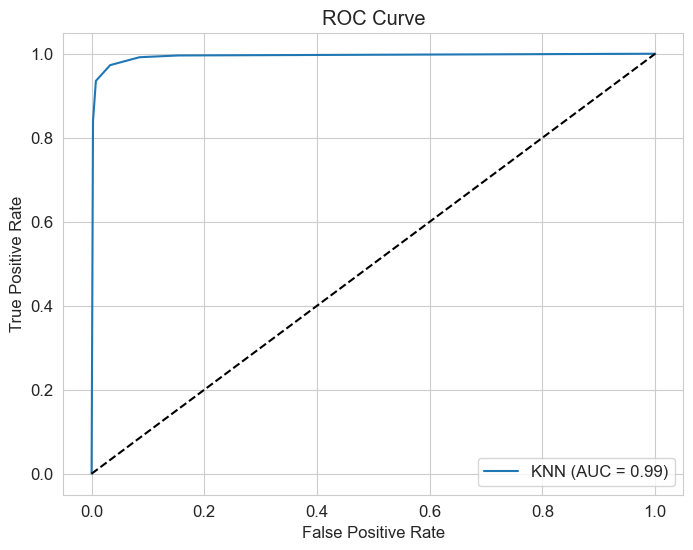

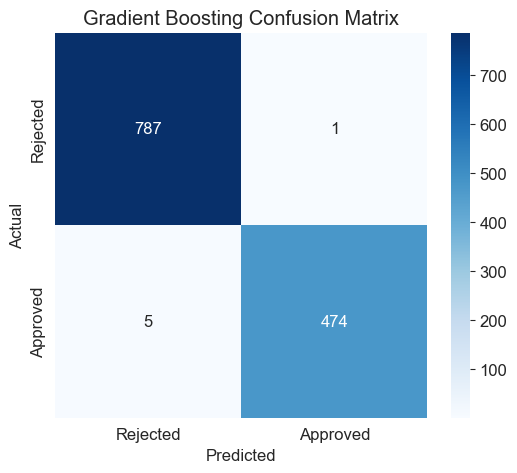

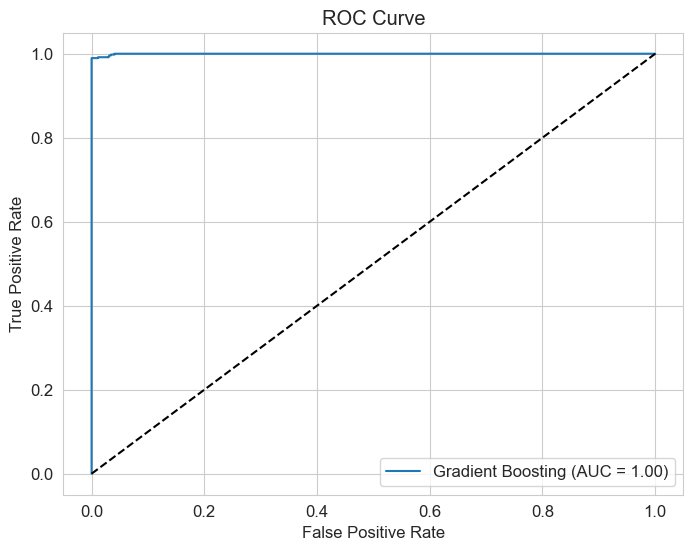


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
2,Random Forest,0.996054,0.996079,0.996054,0.996050,0.999575
5,Gradient Boosting,0.995264,0.995278,0.995264,0.995260,0.999691
1,Decision Tree,0.992897,0.992895,0.992897,0.992895,0.992243
4,KNN,0.969219,0.969589,0.969219,0.969297,0.993669
3,SVM,0.966851,0.967487,0.966851,0.966965,0.996453
0,Logistic Regression,0.939227,0.941265,0.939227,0.939589,0.974606


<Figure size 1200x800 with 0 Axes>

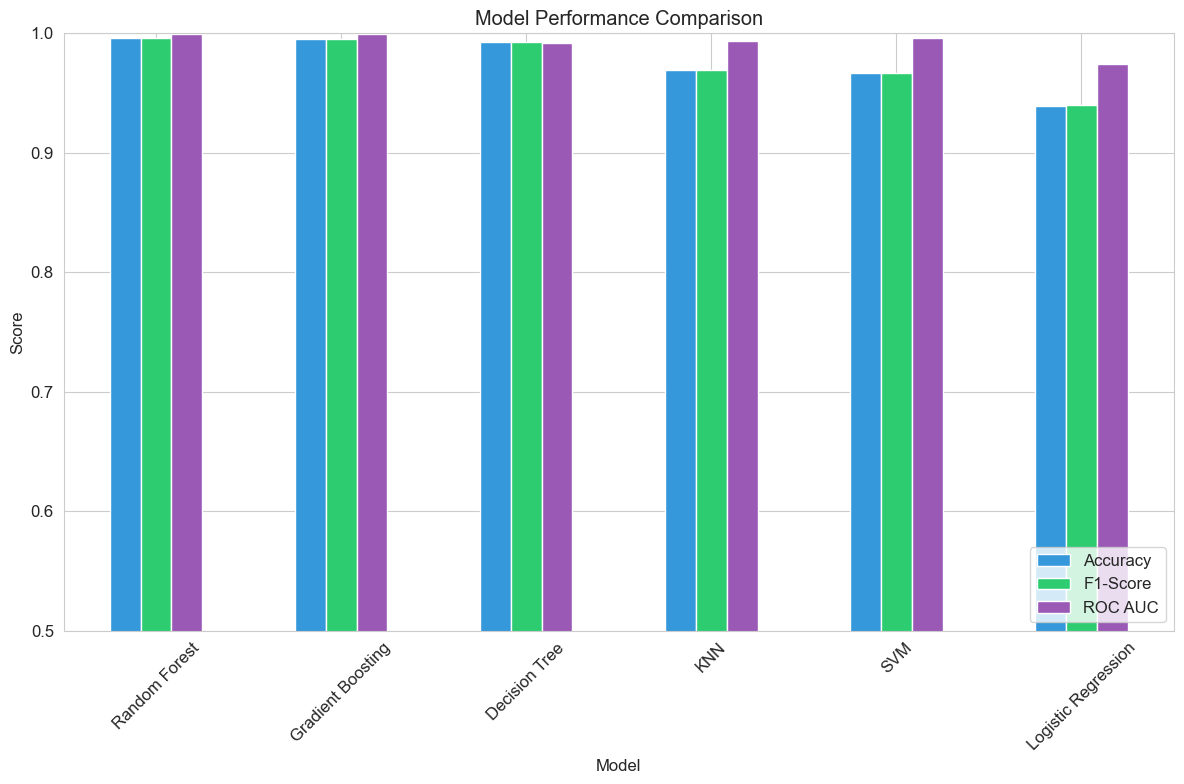


Best model saved as 'loan_approval_model.pkl'


In [13]:
if __name__ == "__main__":
    main()

##### Conclusion
This project successfully demonstrates the effectiveness of machine learning and deep learning in loan approval automation. Through thorough data preprocessing, feature engineering, and model evaluation, the system achieves high accuracy and reliable performance in predicting loan approvals.

Among all the models tested, the Random Forest Classifier provided the best performance, making it the ideal choice for deployment. Additionally, the deep learning model showed promising results, indicating the potential for further improvements.

By automating loan approvals, this system can:

✅ Improve decision-making speed

✅ Enhance accuracy & reduce human bias

✅ Optimize risk assessment for banks & financial institutions

##### Future Work
Although this project achieves high accuracy, there is always room for improvement. Some areas for future enhancements include:

🔹 Hyperparameter Tuning: Further fine-tuning ML and deep learning models using techniques like Bayesian Optimization and Grid Search.

🔹 Explainability & Interpretability: Implement SHAP and LIME to interpret model decisions transparently.

🔹 Integration with Real-Time Systems: Deploy the model as a web application (Flask/Django) or integrate it into a banking system for real-time predictions.

🔹 Advanced Deep Learning Architectures: Explore more sophisticated models like LSTM (Long Short-Term Memory) for sequential data processing.

🔹 Improved Data Handling: Use automated data pipelines and integrate the system with real-world financial datasets.